In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d import axes3d
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

In [2]:
#load data
from google.colab import drive
drive.mount('/content/drive/')
path = "/content/drive/MyDrive/Colab Notebooks"

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [3]:
df = pd.read_csv(os.path.join(path, "normal.csv"))

In [4]:
df

,x,y,z,label
0,0.508974,0.072000,-0.857766,1
1,-0.170812,-0.137027,-0.975729,1
2,0.180624,0.029084,-0.983122,1
3,0.055474,-0.280461,-0.958261,1
4,0.200455,0.102659,-0.974309,1
...,...,...,...,...
490,-0.264893,0.153064,-0.952052,1
491,-0.299151,-0.244966,-0.922226,1
492,0.976401,0.150315,-0.155072,0
493,-0.315728,0.688698,-0.652695,0


In [5]:
X = df.drop(labels=['label'],axis=1).values
y = df['label'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

print('train shape:', X_train.shape)
print('test shape:', X_test.shape)
print(y_train.shape)
print(y_test.shape)

train shape: (346, 3)
test shape: (149, 3)
(346,)
(149,)


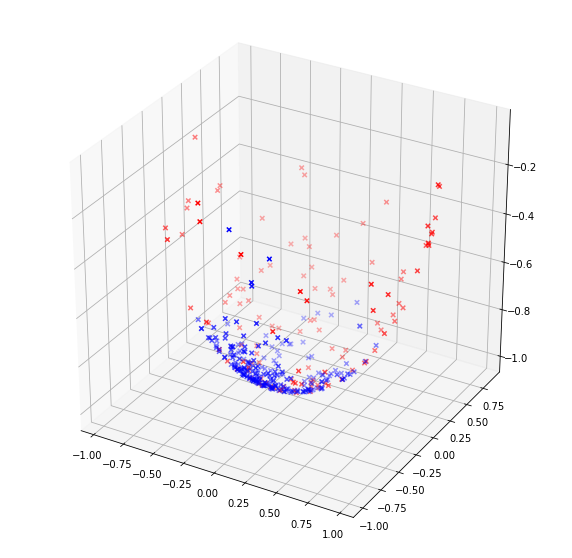

In [6]:
fig = plt.figure(figsize=(10, 10))
ax = plt.axes(projection='3d')

# get indices of points with groundtruth label equal to 0
inds_zero = np.where(y_train==0)
# get indices of points with groundtruth label equal to 1
inds_one = np.where(y_train==1)

# Data for three-dimensional scattered points
x_0 = X_train[inds_zero,0]
y_0 = X_train[inds_zero,1]
z_0 = X_train[inds_zero,2]

x_1 = X_train[inds_one,0]
y_1 = X_train[inds_one,1]
z_1 = X_train[inds_one,2]

ax.scatter3D(x_0, y_0, z_0, c='red', marker='x', label=1)
ax.scatter3D(x_1, y_1, z_1, c='blue', marker='x', label=0)

In [7]:
def normalize_features(X, mean_vector=None, std_vector=None):
    """
        :param X            : 3D array of our dataset, with shape NxD. N is the number of rows (each row is a sample) and D is the number of columns
        :param mean_vector  : optionally given, precomputed vector of mean values.
        :param std_vector   : optionally given, precomputed vector of standard deviation values.
        
        If the function is called passing *only X* as input argument, then the mean and std values will be computed from X, and then X will be normalized using these values.
        If the function is called passing *all three* input arguments, X array will be normalized using the precomputed mean and std values that were passed as input arguments.
        
        Normalization is performed by subtracting the mean and dividing by the standard deviation: x_normalized = (x - x_mean)/(x_std+ε)
    """
    
    if (mean_vector is None) and (std_vector is None):
        return_mean_std = True
        # get the mean for every column
        mean_vector = np.mean(X, axis=0)
        # get the std for every column
        std_vector = np.std(X, axis=0)
        
        # insert extra singleton dimension, to obtain 1xD shape
        mean_vector = np.expand_dims(mean_vector, axis=0)
        std_vector = np.expand_dims(std_vector, axis=0)
    else:
        return_mean_std = False
    
    # get the number of samples in the dataset
    N = X.shape[0]
    
    # repeat N times across first dimension, to obtain NxD shape
    repeated_mean = np.repeat(mean_vector, N, axis=0)
    repeated_std = np.repeat(std_vector, N, axis=0)
    
    #if np.sum(1.0*(repeated_std==0))>0:
    if np.any(repeated_std==0):
        print('Adding epsilon to avoid division by zero during normalization')
        repeated_std += np.finfo(float).eps
    # subtract column mean and divide each element by column standard deviation
    X_normalized = (X - repeated_mean) / repeated_std
    print('Dataset normalization complete.')
    
    if return_mean_std==True:
        return X_normalized, mean_vector, std_vector
    else:
        return X_normalized

In [8]:
def calculate_hypothesis(X, theta, i):
    """
        :param X      : 3D array of our dataset
        :param theta  : 1D array of the trainable parameters
        :param i      : scalar, index of current training sample's row
    """
    #hypothesis = 0.0
    hypothesis = X[i].dot(theta)
    result = 1/(1 + np.exp(-hypothesis))
    return result

In [9]:
def compute_cost(X, y, theta):
    """
        :param X            : 3D array of our dataset
        :param y            : 1D array of the groundtruth labels of the dataset
        :param theta        : 1D array of the trainable parameters
    """

    # initialize cost
    J = 0.0
    # get number of training examples
    m = y.shape[0]

    # Compute cost for logistic regression.
    for i in range(m):
        hypothesis = calculate_hypothesis(X, theta, i)
        output = y[i]
        #cost = 0.0
        cost = (-output*np.log(hypothesis))-((1-output)*np.log(1-hypothesis))
        J += cost
    J = J/m
    return J

In [10]:
def gradient_descent(X, y, theta, alpha, iterations):
    """
        :param X            : 3D array of our dataset
        :param y            : 1D array of the groundtruth labels of the dataset
        :param theta        : 1D array of the trainable parameters
        :param alpha        : scalar, learning rate
        :param iterations   : scalar, number of gradient descent iterations
    """
    m = X.shape[0] # training samples is the number of rows of array X
    cost_vector = np.array([], dtype=np.float32) # empty array to store the cost for every iteration
    # Gradient Descent
    for it in range(iterations):
        # initialize temporary theta, as a copy of the existing theta array
        theta_temp = theta.copy()
        sigma = np.zeros((len(theta)))
        for i in range(m):
            hypothesis = calculate_hypothesis(X, theta, i)
            output = y[i]
            sigma = sigma + (hypothesis - output) * X[i]
        theta_temp = theta_temp - (alpha/m) * sigma
        theta = theta_temp.copy()
        iteration_cost = compute_cost(X, y, theta)
        cost_vector = np.append(cost_vector, iteration_cost)
    print('Gradient descent finished.')
    return theta, cost_vector

In [49]:
def predict(X, y, theta):
    """
        :param X            : 3D array of our dataset
        :param y            : 1D array of the groundtruth labels of the dataset
        :param theta        : 1D array of the trainable parameters
    """
    p = []
    t = 0.5
    for i in X:
        x = np.array(i)
        hypothesis = x.dot(theta)
        result = 1/(1 + np.exp(-hypothesis))
        if result > t:
          p.append(1)
        else:
          p.append(0)
    return p

In [12]:
theta = np.zeros((4))
alpha = 5
iterations = 100

# Normalize and initialize
column_of_ones = np.ones((X_train.shape[0], 1))
# append column to the dimension of columns (i.e., 1)
X_normalized = np.append(column_of_ones, X_train, axis=1)

#Train
theta_final, cost_vector = gradient_descent(X_normalized, y_train, theta, alpha, iterations)

Gradient descent finished.


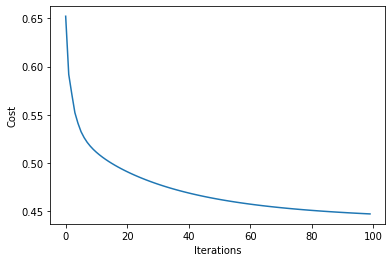

In [13]:
# Cost
# Plot the cost for all iterations
fig, ax1 = plt.subplots()
ax1.set_xlabel('Iterations')
ax1.set_ylabel('Cost')
ax1.plot(cost_vector)

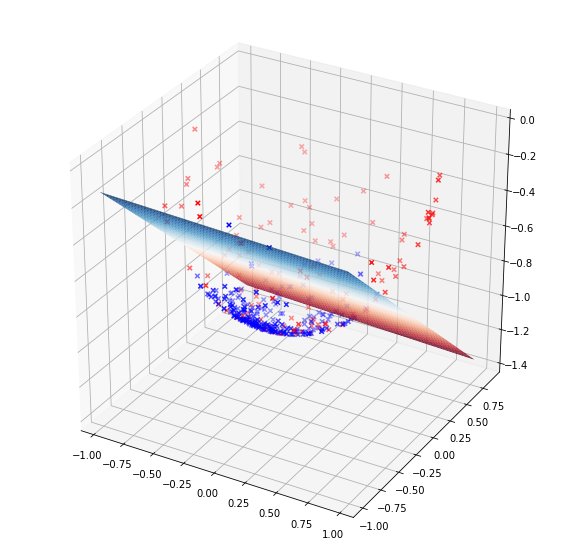

In [68]:
#Decision Boundary
fig = plt.figure(figsize=(10, 10))
ax = plt.axes(projection='3d')
# get indices of points with groundtruth label equal to 0
inds_zero = np.where(y_train==0)
# get indices of points with groundtruth label equal to 1
inds_one = np.where(y_train==1)

# Data for three-dimensional scattered points
x_0 = X_train[inds_zero,0]
y_0 = X_train[inds_zero,1]
z_0 = X_train[inds_zero,2]

x_1 = X_train[inds_one,0]
y_1 = X_train[inds_one,1]
z_1 = X_train[inds_one,2]

ax.scatter3D(x_0, y_0, z_0, c='red', marker='x', label=1)
ax.scatter3D(x_1, y_1, z_1, c='blue', marker='x', label=0)

# Decision boundary
xdata = np.linspace(max(X_train[:,0]),min(X_train[:,0]),100)
ydata = np.linspace(max(X_train[:,1]),min(X_train[:,1]),100)
X,Y = np.meshgrid(xdata,ydata)
Z = []
for j in ydata:
    temp = []
    for i in xdata:
        r = -(theta_final[0]+theta_final[1]*i+theta_final[2]*j)/theta_final[3]
        temp.append(r)
    Z.append(temp)
Z_np = np.array(Z)
ax.plot_surface(X, Y, Z_np,cmap='RdBu')
plt.show()

In [50]:
# Test
TP = 0
FP = 0
FN = 0
TN = 0
# Normalize and initialize
column_of_ones = np.ones((X_test.shape[0], 1))
# append column to the dimension of columns (i.e., 1)
X_test_normalized = np.append(column_of_ones, X_test, axis=1)
pred = predict(X_test_normalized, y_test, theta_final)
for i in range (len(pred)):
    if pred[i] == y_test[i] ==0:
        TP = TP+1
    elif pred[i] ==0 and y_test[i] ==1:
        FP = FP+1
    elif pred[i] == 1 and y_test[i] ==0:
        FN = FN+1
    elif pred[i] == y_test[i] ==1:
        TN = TN+1

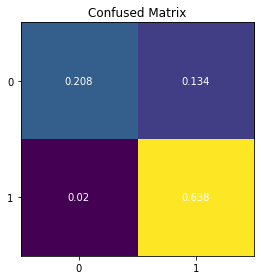

In [51]:
# Confused matrix
l = ["0","1"]
p = ["0","1"]

Total = TP + FP + FN + TN
data = np.array([[round(TP/Total,3),round(FN/Total,3)],
                 [round(FP/Total,3),round(TN/Total,3)]])

fig, ax = plt.subplots()
im = ax.imshow(data)

ax.set_xticks(np.arange(len(p)))
ax.set_yticks(np.arange(len(l)))
ax.set_xticklabels(p)
ax.set_yticklabels(l)

for i in range(len(l)):
    for j in range(len(p)):
        text = ax.text(j, i, data[i, j],
                       ha="center", va="center", color="w")

ax.set_title("Confused Matrix")
fig.tight_layout()
plt.show()

In [52]:
#Accuracy
print("Accuracy:", (TP+TN)/Total)
#Precision
print("Precision:", TP/(TP+FP))

Accuracy: 0.8456375838926175
Precision: 0.9117647058823529
